In [ ]:
!pip install tensorflow

In [ ]:
!pip install torchinfo
!pip install torchmetrics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 805.2/805.2 kB 9.3 MB/s eta 0:00:00


In [ ]:
pip install matplotlib


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import cv2
import os
from sklearn.model_selection import train_test_split as tts
from pathlib import Path
import random
import torch
from torch import nn,optim
from typing import Dict,List
from torchinfo import summary
from torchmetrics.classification import BinaryAccuracy
from torch.utils.data import Dataset,DataLoader
from torchvision import transforms
from torchvision.models import efficientnet_b2

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
images_path = Path('/content/drive/MyDrive/brain_mri_scan_images')
total_classes = os.listdir(images_path)
print(f"Total classes = {total_classes}")

Total classes = ['negative', 'positive']


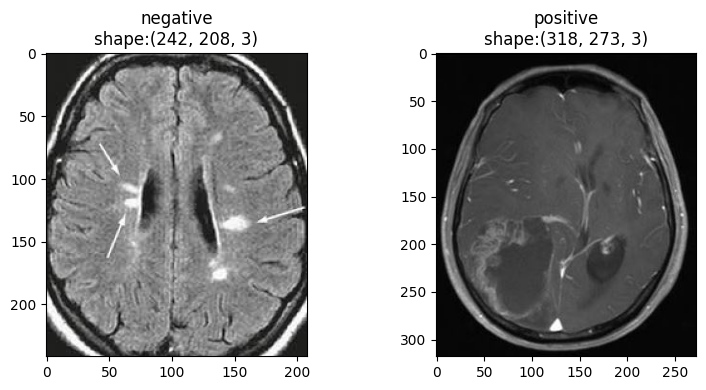

In [ ]:
## Let's display 1 image for each class.

images_path_list = list(images_path.glob("*/*.jpg"))

fig,ax = plt.subplots(nrows = 1, ncols = 2, figsize = (8,4))
ax = ax.flat

for i,c in enumerate(total_classes):
    img_path_class = Path(os.path.join(images_path, c))
    img_path_list = list(img_path_class.glob("*.jpg"))
    img_selected = random.choice(img_path_list)
    img_BGR = cv2.imread(str(img_selected))
    img_RGB = cv2.cvtColor(img_BGR, cv2.COLOR_BGR2RGB)
    ax[i].imshow(img_RGB)
    ax[i].set_title(f"{img_selected.parent.stem}\nshape:{img_RGB.shape}")

fig.tight_layout()
fig.show()


In [ ]:
# Initialize a dictionary to store the counts per class
class_counts = {}

# Traverse the root directory and its subdirectories
for class_name in os.listdir(images_path):
    class_dir = os.path.join(images_path, class_name)

    if os.path.isdir(class_dir):
        # Count the number of image files in each class directory
        class_count = len([file for file in os.listdir(class_dir) if file.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp', '.gif', '.tiff', '.webp'))])
        class_counts[class_name] = class_count

# Display the number of images per class
for class_name, count in class_counts.items():
    print(f"Class: {class_name} - Number of Images: {count}")


Class: negative - Number of Images: 98
Class: positive - Number of Images: 129


In [ ]:
image_path_and_class = {"image_path":[],
                      "target":[]}

for img_path in images_path_list:
    image_path_and_class["image_path"].append(img_path)
    image_path_and_class["target"].append(img_path.parent.stem)

df_image_path_and_class = pd.DataFrame(image_path_and_class)
df_image_path_and_class.head()

,image_path,target
0,/content/drive/MyDrive/brain_mri_scan_images/n...,negative
1,/content/drive/MyDrive/brain_mri_scan_images/n...,negative
2,/content/drive/MyDrive/brain_mri_scan_images/n...,negative
3,/content/drive/MyDrive/brain_mri_scan_images/n...,negative
4,/content/drive/MyDrive/brain_mri_scan_images/n...,negative


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Assuming you have a DataFrame named df_image_path_and_class
# containing columns 'image_path' and 'target'

# Split the data into X (features) and y (target)
X = df_image_path_and_class['image_path']
y = df_image_path_and_class['target']

# Split the data into a training and testing set
train_set, test_set = train_test_split(df_image_path_and_class, test_size=0.2, random_state=1993)

# Quick check to see that the training and test set were split properly
print('training set - # of observations: ', len(train_set))
print('test set - # of observations: ', len(test_set))
print('prior, full data set - # of observations: ', len(df_image_path_and_class))


training set - # of observations:  181
test set - # of observations:  46
prior, full data set - # of observations:  227


In [ ]:
# Assuming the "image_path" column may contain non-string values
df_image_path_and_class['image_path'] = df_image_path_and_class['image_path'].apply(lambda x: str(x))

# Now, all values in the "image_path" column should be strings


In [ ]:
# ImageDataGenerator for data augmentation and normalization
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator



In [ ]:

# Define the parameters
image_size = (128, 128)
batch_size = 32
epochs = 10


In [ ]:

datagen = ImageDataGenerator(
    rescale=1.0 / 255,  # Normalize pixel values
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.3
)
# Create data generators for training and testing
train_generator = datagen.flow_from_dataframe(
    df_image_path_and_class,
    x_col='image_path',
    y_col='target',
    subset='training',  # For training set
    class_mode='categorical',  # Change to 'binary' if you have two classes
    target_size=image_size,  # Define image size
    batch_size=batch_size
)

test_generator = datagen.flow_from_dataframe(
    df_image_path_and_class,
    x_col='image_path',
    y_col='target',
    subset='validation',  # For testing set
    class_mode='categorical',  # Change to 'binary' if you have two classes
    target_size=image_size,  # Define image size
    batch_size=batch_size
)


Found 159 validated image filenames belonging to 2 classes.
Found 68 validated image filenames belonging to 2 classes.


In [ ]:

num_classes = 2  # Tumor (1) or No Tumor (0)

# Create the CNN model
model = models.Sequential()
model.add(layers.Conv2D(128, (3, 3), activation='relu', input_shape=(image_size[0], image_size[1], 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(num_classes, activation='softmax'))

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Train the model
history = model.fit(train_generator, epochs=epochs, validation_data=test_generator)

# Save the model
model.save('tumor_detection_model.h5')


Epoch 1/10
5/5 [==============================] - 53s 11s/step - loss: 0.6709 - accuracy: 0.6541 - val_loss: 0.8930 - val_accuracy: 0.0000e+00
Epoch 2/10
5/5 [==============================] - 18s 3s/step - loss: 0.4813 - accuracy: 0.8113 - val_loss: 2.3570 - val_accuracy: 0.0000e+00
Epoch 3/10
5/5 [==============================] - 18s 4s/step - loss: 0.4432 - accuracy: 0.8113 - val_loss: 1.2559 - val_accuracy: 0.0000e+00
Epoch 4/10
5/5 [==============================] - 15s 3s/step - loss: 0.4343 - accuracy: 0.8113 - val_loss: 1.7350 - val_accuracy: 0.0000e+00
Epoch 5/10
5/5 [==============================] - 16s 3s/step - loss: 0.4402 - accuracy: 0.8113 - val_loss: 1.4498 - val_accuracy: 0.0000e+00
Epoch 6/10
5/5 [==============================] - 15s 3s/step - loss: 0.4366 - accuracy: 0.8176 - val_loss: 1.4276 - val_accuracy: 0.0000e+00
Epoch 7/10
5/5 [==============================] - 16s 3s/step - loss: 0.4056 - accuracy: 0.8113 - val_loss: 1.9152 - val_accuracy: 0.0000e+00
Epoch

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1/1 [==============================] - 0s 129ms/step


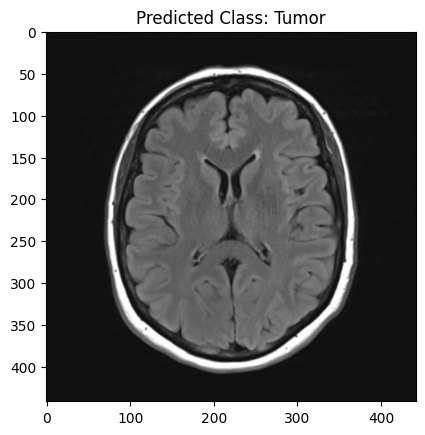

In [ ]:
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# Load the trained model
model = load_model('tumor_detection_model.h5')

# Define a function to load and preprocess an image
def preprocess_image(image_path, target_size):
    image = load_img(image_path, target_size=target_size)
    image = img_to_array(image)
    image = image / 255.0  # Normalize pixel values
    image = np.expand_dims(image, axis=0)  # Add a batch dimension
    return image

# Choose a random image from your dataset
random_index = random.randint(0, len(df_image_path_and_class) - 1)
random_image_path = df_image_path_and_class['image_path'].iloc[random_index]
random_image = preprocess_image(random_image_path, image_size)

# Make a prediction using the model
prediction = model.predict(random_image)

# Determine the class label based on the prediction
class_labels = ['Non-Tumor', 'Tumor']
predicted_class = class_labels[np.argmax(prediction)]

# Display the selected image and the prediction result
plt.imshow(load_img(random_image_path))
plt.title(f'Predicted Class: {predicted_class}')
plt.show()


In [ ]:
import cv2
import numpy as np
from skimage.feature import greycomatrix, greycoprops

# Load grayscale images from file paths and store them in a list
grayscale_images = [cv2.imread(str(image_path), cv2.IMREAD_GRAYSCALE) for image_path in X]
# Use str() to ensure image_path is a string

# Step 2: Image Segmentation
# Implement image segmentation techniques to isolate the tumor region.
# This example uses simple thresholding for illustration.

def segment_tumor(gray_image):
    # Apply a threshold to segment the tumor region
    _, segmented_image = cv2.threshold(gray_image, 128, 255, cv2.THRESH_BINARY)

    return segmented_image

# Apply segmentation to all grayscale images
segmented_images = [segment_tumor(image) for image in grayscale_images]

# Step 3: Feature Extraction
# Extract features from the segmented images.

def extract_features(image):
    # Example: Compute texture features using GLCM (Gray-Level Co-occurrence Matrix)
    glcm = greycomatrix(image, [1], [0], symmetric=True, normed=True)
    contrast = greycoprops(glcm, 'contrast')[0, 0]
    energy = greycoprops(glcm, 'energy')[0, 0]

    return [contrast, energy]

# Extract features for all segmented images
X_features = [extract_features(image) for image in segmented_images]


In [ ]:
X_features

In [ ]:

import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# Machine Learning
# Split the data into training and testing sets and train a classifier

X_train, X_test, y_train, y_test = train_test_split(X_features, y, test_size=0.2, random_state=1993)

# Train a simple classifier (e.g., Random Forest)
classifier = RandomForestClassifier(n_estimators=100)
classifier.fit(X_train, y_train)

# Step 5: Prediction and Post-Processing
# Make predictions and optionally perform post-processing to improve results

y_pred = classifier.predict(X_test)

# Step 6: Validation and Evaluation
# Evaluate the model's performance (e.g., accuracy)

accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy * 100:.2f}%')


Accuracy: 71.74%


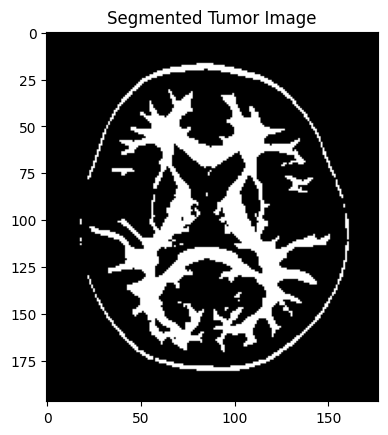

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.feature import greycomatrix, greycoprops
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# Load grayscale images from file paths and store them in a list
grayscale_images = [cv2.imread(str(image_path), cv2.IMREAD_GRAYSCALE) for image_path in X]

# Step 2: Image Segmentation
# Implement image segmentation techniques to isolate the tumor region.
# This example uses simple thresholding for illustration.

def segment_tumor(gray_image):
    # Apply a threshold to segment the tumor region
    _, segmented_image = cv2.threshold(gray_image, 128, 255, cv2.THRESH_BINARY)

    return segmented_image

# Apply segmentation to all grayscale images
segmented_images = [segment_tumor(image) for image in grayscale_images]

# Display the first segmented tumor image
plt.imshow(segmented_images[0], cmap='gray')
plt.title('Segmented Tumor Image')
plt.show()

# Store the rest of the segmented images in a variable
rest_segmented_images = segmented_images[1:]

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
import cv2
import matplotlib.pyplot as plt

# Load and preprocess the segmented images
# `rest_segmented_images` is assumed to contain the segmented tumor images
preprocessed_images = [cv2.resize(image, (64, 64)) for image in rest_segmented_images]
preprocessed_images = np.array(preprocessed_images, dtype=float) / 255.0

# Create a generator model
generator = models.Sequential([
    layers.Dense(64 * 64, input_shape=(128,), activation='relu'),
    layers.Reshape((64, 64, 1)),  # Adjust the reshape to produce images with (64, 64, 1)
    layers.Conv2DTranspose(64, (5, 5), activation='relu', padding='same'),
    layers.Conv2DTranspose(1, (5, 5), activation='sigmoid', padding='same')
])

generator.save('generator.h5')

# Create a discriminator model
discriminator = models.Sequential([
    layers.Conv2D(32, (5, 5), activation='relu', input_shape=(64, 64, 1)),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Flatten(),
    layers.Dense(1, activation='sigmoid')
])

# Compile the discriminator
discriminator.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Combine the generator and discriminator into a GAN
discriminator.trainable = False
gan_input = layers.Input(shape=(128,))
x = generator(gan_input)
gan_output = discriminator(x)
gan = models.Model(gan_input, gan_output)
gan.compile(loss='binary_crossentropy', optimizer='adam')
gan.save('gan.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1/1 [==============================] - 0s 151ms/step
Epoch 0, D Loss: 0.22930729389190674, G Loss: 1.0558247566223145
1/1 [==============================] - 0s 88ms/step
Epoch 2, D Loss: 0.027482403442263603, G Loss: 3.8792266845703125
1/1 [==============================] - 0s 84ms/step
Epoch 4, D Loss: 0.007450350094586611, G Loss: 4.215043067932129
1/1 [==============================] - 0s 80ms/step
Epoch 6, D Loss: 0.004298363346606493, G Loss: 4.788100719451904
1/1 [==============================] - 0s 86ms/step
Epoch 8, D Loss: 0.01720740832388401, G Loss: 4.376948356628418
1/1 [==============================] - 0s 82ms/step
Epoch 10, D Loss: 0.0034428935032337904, G Loss: 4.9833173751831055
1/1 [==============================] - 0s 84ms/step
Epoch 12, D Loss: 0.00510776974260807, G Loss: 4.623435974121094
1/1 [==============================] - 0s 125ms/step
Epoch 14, D Loss: 0.00811060518026352, G Loss: 4.113738059997559
1/1 [==============================] - 0s 88ms/step
Epoch 1

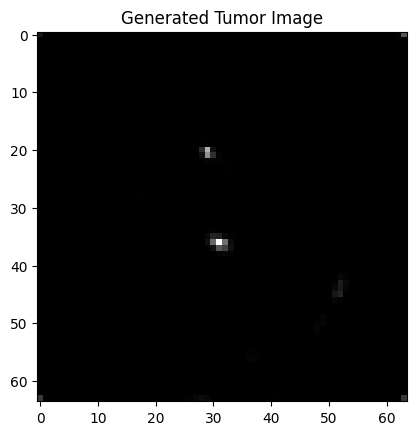

In [ ]:
# Training loop
batch_size = 8
epochs = 20

for epoch in range(epochs):
    for _ in range(len(preprocessed_images) // batch_size):
        noise = np.random.rand(batch_size, 128)  # Match the generator's input shape
        generated_images = generator.predict(noise)
        real_images = preprocessed_images[np.random.choice(len(preprocessed_images), batch_size, replace=False)]
        real_images = np.expand_dims(real_images, axis=-1)  # Add a new dimension for channels

        # Train the discriminator
        real_labels = np.ones((batch_size, 1))
        fake_labels = np.zeros((batch_size, 1))
        x = np.vstack((real_images, generated_images))
        y = np.vstack((real_labels, fake_labels))
        discriminator_loss = discriminator.train_on_batch(x, y)

        # Train the generator
        noise = np.random.rand(batch_size, 128)  # Keep this input shape consistent
        y = np.ones((batch_size, 1))
        generator_loss = gan.train_on_batch(noise, y)

    if epoch % 2 == 0:
        print(f"Epoch {epoch}, D Loss: {discriminator_loss[0]}, G Loss: {generator_loss}")

# Generate tumor images
noise = np.random.rand(1, 128)
generated_tumor_image = generator.predict(noise)[0]
plt.imshow(generated_tumor_image[:, :, 0], cmap='gray')
plt.title('Generated Tumor Image')
plt.show()

In [ ]:
import cv2

def check_image_format(image_path):
    # Read the image
    image = cv2.imread(image_path, cv2.IMREAD_UNCHANGED)

    # Check the number of channels
    num_channels = image.shape[2] if len(image.shape) == 3 else 1

    # Determine the image format based on the number of channels
    if num_channels == 3:
        return "RGB"
    elif num_channels == 1:
        # Check if the image is binary or grayscale
        unique_values = np.unique(image)
        if len(unique_values) == 2:
            return "Binary"
        else:
            return "Grayscale"
    else:
        return "Unknown"

# Example usage
image_path = "/content/drive/MyDrive/brain_mri_scan_images/positive/100.jpg"
image_format = check_image_format(image_path)
print(f"The image format is: {image_format}")


The image format is: RGB


Enter the path to the RGB tumor image: /content/drive/MyDrive/brain_mri_scan_images/positive/100.jpg


/usr/local/lib/python3.10/dist-packages/skimage/feature/__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
/usr/local/lib/python3.10/dist-packages/skimage/feature/__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
/usr/local/lib/python3.10/dist-packages/skimage/feature/__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')


1/1 [==============================] - 0s 192ms/step


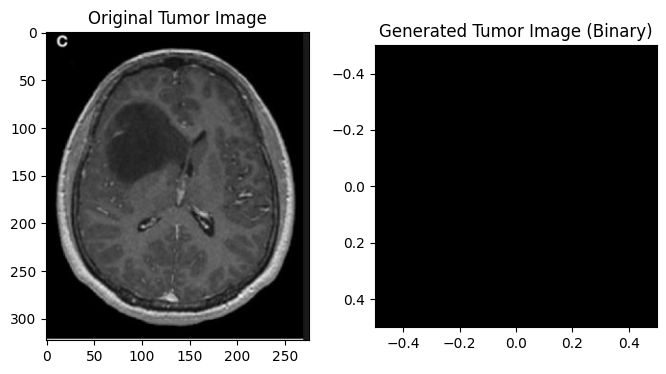

In [ ]:
import cv2
import numpy as np
from skimage.feature import greycomatrix, greycoprops
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt

def segment_tumor(gray_image):
    _, segmented_image = cv2.threshold(gray_image, 128, 255, cv2.THRESH_BINARY)
    return segmented_image

def extract_features(image):
    glcm = greycomatrix(image, [1], [0], symmetric=True, normed=True)
    contrast = greycoprops(glcm, 'contrast')[0, 0]
    energy = greycoprops(glcm, 'energy')[0, 0]
    return [contrast, energy]

def preprocess_input(image_path):
    # Read the RGB image
    rgb_image = cv2.imread(image_path, cv2.IMREAD_COLOR)

    # Convert RGB to grayscale
    gray_image = cv2.cvtColor(rgb_image, cv2.COLOR_BGR2GRAY)

    # Segment the tumor
    segmented_image = segment_tumor(gray_image)

    # Extract features
    features = extract_features(segmented_image)

    return np.array(features)

def generate_tumor_image(generator, noise):
    generated_tumor_image = generator.predict(noise)[0]
    return generated_tumor_image.reshape(generated_tumor_image.shape[0], generated_tumor_image.shape[-1])

def main():
    # Load the pre-trained GAN model
    generator = models.load_model('gan.h5')  # Replace with the actual path

    # Prompt for input image path
    input_image_path = input("Enter the path to the RGB tumor image: ")

    # Preprocess the input image
    input_features = preprocess_input(input_image_path)

    # Generate tumor image using GAN
    noise = np.random.rand(1, 128)
    generated_tumor_image = generate_tumor_image(generator, noise)

    # Display the original and generated tumor images
    plt.figure(figsize=(8, 4))

    plt.subplot(1, 2, 1)
    plt.imshow(cv2.cvtColor(cv2.imread(input_image_path), cv2.COLOR_BGR2RGB))
    plt.title('Original Tumor Image')

    plt.subplot(1, 2, 2)
    _, generated_tumor_image_thresh = cv2.threshold(generated_tumor_image, 128, 255, cv2.THRESH_BINARY)
    plt.imshow(generated_tumor_image_thresh, cmap='gray')
    plt.title('Generated Tumor Image (Binary)')

    plt.show()

if __name__ == "__main__":
    main()
